<a href="https://colab.research.google.com/github/SaxenaVaishnavi/Machine-Learning-Practices/blob/main/Week_6/MNIST_Digits_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
**Recap from MLT**
* Logistic regression is the **workhorse** of machine learning.
* Before deep learning era, logistic regression was **the default choice** for solving real life classification problems with hundreds of thousands of features.
* It works in binary, multi-class and multi-label classification set ups.

#Imports
In this notebook we solve the same problem of recognizing Handwritten digits using Logistic regression model.  

In [1]:
# Common imports
import numpy as np
from pprint import pprint
from tempfile import mkdtemp
from shutil import rmtree

# to make this notebook's output stable across runs
np.random.seed(42)

#sklearn specific imports
# Dataset fetching
from sklearn.datasets import fetch_openml

# Feature scaling
from sklearn.preprocessing import MinMaxScaler

# Pipeline utility
from sklearn.pipeline import make_pipeline, Pipeline

# Classifiers: dummy, logistic regression (SGD and LogisticRegression)
# and least square classification
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression, LogisticRegressionCV, RidgeClassifierCV

# Model selection
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.model_selection import learning_curve

# Evaluation metrics
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, roc_curve, roc_auc_score

# scipy
from scipy.stats import loguniform

# To plot pretty figures
%matplotlib inline
from  matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Ignore all warnings (convergence..) by sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Note on the classification steps

Each classifier implemented for addressing this problem has the following steps:

* Preprocessing
* Classification
* Train with cross validation
* [Optional] Hyper-parameter tuning
* Performance evaluation

# Problem Statement - Handwritten Digit Classification

We are going to repeat the digit recognition task with the following classifiers
  1. SGD classifier.
  2. Logistic Regression.
  3. Ridge Classifier.

We make use of same **MNIST** dataset.



In [3]:
# Dataset fetching
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# convert to numpy array
X = X.to_numpy()
y = y.to_numpy()

Split the dataset into training and testing set.

In [4]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Pre-Processing
* **Unlike** perceptron, where scaling the range is optional (but recommended), sigmoid requires scaling the feature range between 0 to 1.
* Contemplate the consequences if we don't apply the scaling operation on the input datapoints.

* Note: **Do not** apply mean centering as it removes zeros from the data, however, zeros should be zeros in the dataset

* Since we already visualized the samples in the dataset and know sufficient details, we are going to use `pipeline` to make the code compact.

#Binary Classification : 0-Detector

Let us start with a simple classification problem, that is, **binary classification**.

Since the original label vector contains 10 classes, we need to modfiy the number of classes to 2. Therefore  
- the label $0$ will be changed to $1$
- all other labels $(1-9)$ will be changed to $0$.

**Important**: for perceptron we set the negative labels to $-1$

In [5]:
# Intialize new variable names with all -1
y_train_0 = np.zeros((len(y_train)))
y_test_0 = np.zeros((len(y_test)))

# Find indices of digit 0 image
indx_0 = np.where(y_train == '0') # Remember original labels are of type str not int

# Use those indices to modify y_train_0 & y_test_0
y_train_0[indx_0] = 1

indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

**Sanity check⚛** <br>
Let's display the elements of `y_train` and `y_train_0` to verify whether the labels are properly modified.

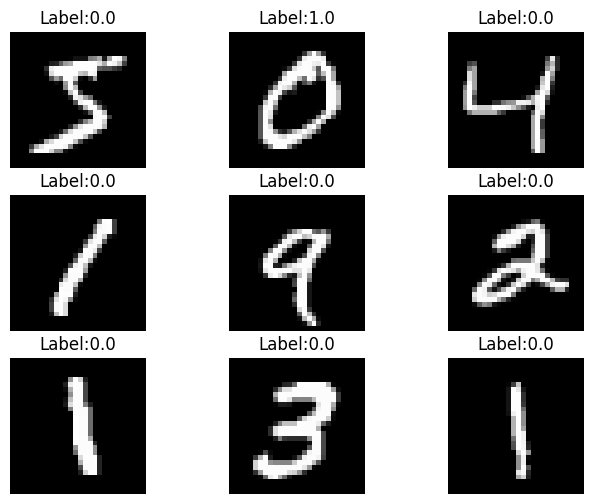

In [6]:
num_images = 9            # Choose a square number
factor = int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8,6))
idx_offset = 0            # Take "num_images" starting from the index "idx_offset"

for i in range(factor):
  index = idx_offset + i * (factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y_train_0[index+j])))
    ax[i,j].set_axis_off()

## Basline Models
We already know that the basline model would produce an accuracy of 90.12%.

In [7]:
base_clf = DummyClassifier(strategy = 'most_frequent')
base_clf.fit(x_train, y_train_0)
print(base_clf.score(x_train, y_train_0))

0.9012833333333333


# Part 1 - SGD Classifier

 Before using LogisticRegression for Binary classification problem, let's recall important concepts and equations covered in MLT.

## Recap
Let us quickly recap various components in the general settings:
1.  **Training data**: (features, label) or $(\mathbf{X}, y)$, where label $y$ is a **discrete** quantity from a finite set. **Features** in this case are pixel values of an image.
2. **Model :**
 \begin{eqnarray}
z &=& {w_0} {x_0} + {w_1} x_1 + {w_2} x_2 + \ldots + {w_m} x_m \\
&=& \mathbf{w}^T\mathbf{x}
\end{eqnarray}
and passing it through the sigmoid non-linear function (or Logistic function)
$$ \sigma(z) = \dfrac{1}{1+e^{-z}} =\dfrac{1}{1+exp(-z)} $$
3.**Loss function:** We use Binary cross entropy loss.
$$ J(\mathbf{w}) = -\dfrac{1}{n}\sum\left[y^{(i)} \log(h_{\mathbf{w}}(\mathbf{x}^{(i)}))+ (1-y^{(i)})(1- \log(h_{\mathbf{w}}(\mathbf{x}^{(i)})))\right]$$
4.**Optimization:** <br>
  Gradient Descent

Let's look into the paramters of the `SGDClassifier()` estimator implemented in sklearn:

```python
class sklearn.linear_model.SGDClassifier(loss='hinge', *, penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000,
                                        tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None,
                                        learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1,
                                        n_iter_no_change=5, class_weight=None, warm_start=False, average=False)
```

Setting the loss parameter to `loss=log_loss` makes it a **logistic regression classifier**.  Refer to documentation for more details on the `SGDClassifier` class.




## Training without regularization

* Let's instatiate an object of SGDClassifier.
* Since we want to plot learning curve of training, we set `max_iter = 1` and `warm_start = True`.
* In addition, we are using constant learning rate throughout the training.  For that we set `learning_rate = 'constant'` and set the learning rate through `eta0 = 0.01`.
* Since we are not using regularization, we set `alpha = 0`.

In [9]:
estimator = SGDClassifier(loss = 'log_loss',
                        penalty = 'l2',
                        max_iter = 1,
                        warm_start = True,
                        eta0 = 0.01,
                        alpha = 0,
                        learning_rate = 'constant',
                        random_state = 1729)

pipe_sgd = make_pipeline(MinMaxScaler(), estimator)

'''
Could've also written the above pipeline like this --

pipe_sgd = Pipeline([
    ('scaler', MinMaxScaler()),
    ('sgd', estimator)
])

`make_pipeline()` automatically names the steps based on their class names, so we don't need to specify names manually. It is used
for quicker and cleaner code, while `Pipeline()` allows us to specify names manually, and is used when we need more control over code.
'''

Let us call `fit` method of `SGDClassifier()` in iterative manner to plot the iteration vs loss curve.

In [10]:
Loss = []
iterations = 100

for i in range(iterations):
  pipe_sgd.fit(x_train, y_train_0)
  y_pred = pipe_sgd.predict_proba(x_train)
  Loss.append(log_loss(y_train_0, y_pred))

Let's plot the learning curve. We have iterator number on the x-axis and loss on the y-axis.

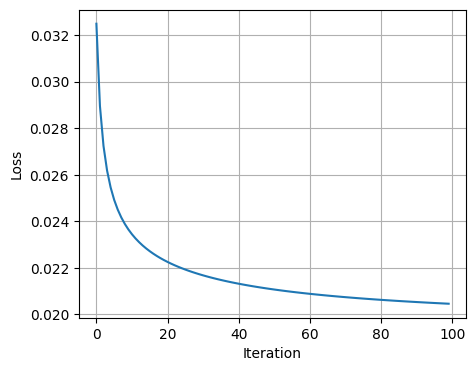

In [11]:
plt.figure(figsize = (5, 4))
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Observe that the loss is reducing for each iteration. It signals us the model is getting trained as per the expectation.

Now that the model is trained, let's us calculate the training and test accuracy of the model.

In [12]:
print('Training accuracy: %.2f'%pipe_sgd.score(x_train, y_train_0))
print('Testing accuracy: %.2f'%pipe_sgd.score(x_test, y_test_0))

Training accuracy: 0.99
Testing accuracy: 0.99


We know that accuracy alone is not a good metric for binary classification. Thus let's compute Precision, recall and f1-score for the model.

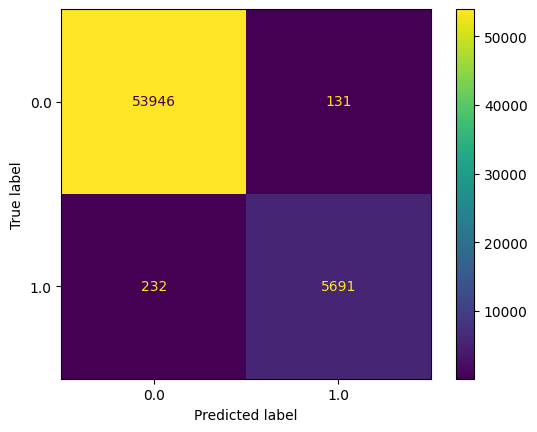

In [13]:
y_hat_train_0 = pipe_sgd.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0)
plt.show()

Observe that the off-diagonal elements are not zero, which indicates that a few examples are misclassified.

In [14]:
print(classification_report(y_train_0, y_hat_train_0, digits=3))

              precision    recall  f1-score   support

         0.0      0.996     0.998     0.997     54077
         1.0      0.977     0.961     0.969      5923

    accuracy                          0.994     60000
   macro avg      0.987     0.979     0.983     60000
weighted avg      0.994     0.994     0.994     60000



Let's generate classification report on test set.

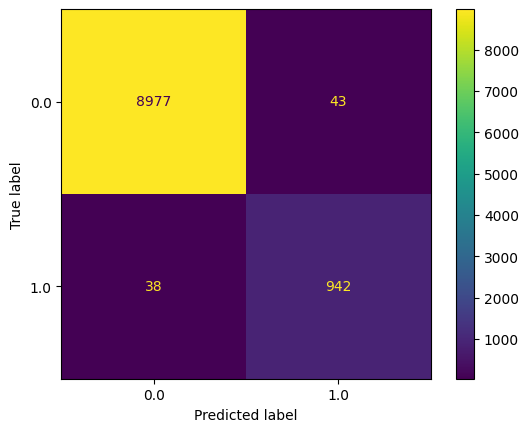

In [15]:
y_hat_test_0 = pipe_sgd.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_test_0)
plt.show()

In [16]:
print(classification_report(y_test_0, y_hat_test_0, digits=3))

              precision    recall  f1-score   support

         0.0      0.996     0.995     0.996      9020
         1.0      0.956     0.961     0.959       980

    accuracy                          0.992     10000
   macro avg      0.976     0.978     0.977     10000
weighted avg      0.992     0.992     0.992     10000



### Cross Validation

In [17]:
estimator = SGDClassifier(loss='log_loss',
                        penalty='l2',
                        max_iter=100,
                        warm_start=False,
                        eta0=0.01,
                        alpha=0,
                        learning_rate='constant',
                        random_state=1729)

# create a pipeline
pipe_sgd_cv = make_pipeline(MinMaxScaler(), estimator)

Now we will train the classifier with cross validation.

In [18]:
cv_bin_clf = cross_validate(pipe_sgd_cv,
                            x_train,
                            y_train_0,
                            cv=5,
                            scoring=['precision', 'recall', 'f1'],
                            return_train_score=True)
pprint(cv_bin_clf)

{'fit_time': array([1.81005549, 1.8202126 , 1.84217691, 2.12856174, 2.15672278]),
 'score_time': array([0.08049655, 0.08073068, 0.08169484, 0.12567091, 0.0855546 ]),
 'test_f1': array([0.95699831, 0.954371  , 0.9616041 , 0.95870583, 0.95993252]),
 'test_precision': array([0.95538721, 0.96382429, 0.97238999, 0.96735395, 0.95952782]),
 'test_recall': array([0.95861486, 0.94510135, 0.95105485, 0.95021097, 0.96033755]),
 'train_f1': array([0.96495899, 0.96565657, 0.96453452, 0.96373944, 0.96302557]),
 'train_precision': array([0.97419355, 0.97321046, 0.96473818, 0.97701149, 0.96404399]),
 'train_recall': array([0.95589787, 0.95821903, 0.96433094, 0.95082313, 0.96200929])}


It is good to check the weight values of all the features which will help us decide whether regularization could be of any help.

In [19]:
# Call the estimator object in the steps of pipeline
weights = pipe_sgd[1].coef_
bias = pipe_sgd[1].intercept_

print('Dimention of Weights w: {0}'.format(weights.shape))
print('Bias :{0}'.format(bias))

Dimention of Weights w: (1, 784)
Bias :[-4.89339106]


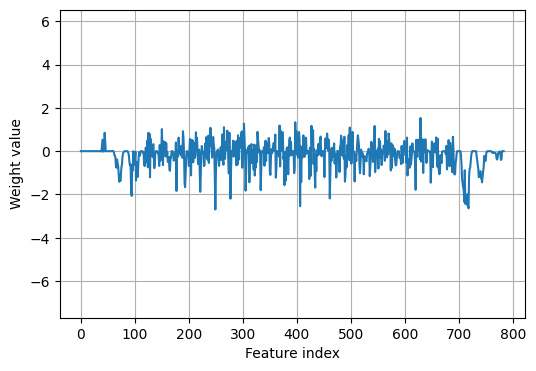

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 784), weights[0, :])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim((np.min(weights)-5, np.max(weights)+5))
plt.grid()

It is interesting to observe how many weight values are exactly zero. Those features contribute nothing in the classification.

In [21]:
num_zero_w = weights.shape[1] - np.count_nonzero(weights)
print('Number of weights with value zero:%f'%num_zero_w)

Number of weights with value zero:67.000000


Looking at the above plot and the performance of the model on training and test, it is obvious that the model does not require any regularization.


## Training with regularization
However, what happens to the performance of the model if we penalize, out of temptation, the weight values to an even smaller degree.

We perform L2 regularization with a small regularization penalty $\alpha=0.001$.

Note that, we instantiate `SGDClassifier` with the following parameters:
```python
`penalty='l2'`
`alpha=0.001`
```



In [22]:
# L2 regularization
estimator = SGDClassifier(loss='log_loss',
                           penalty='l2',
                           alpha=0.001,
                           max_iter=1,
                           eta0=0.01,
                           warm_start=True,
                           learning_rate='constant',
                           random_state=1729)

pipe_sgd_l2 = make_pipeline(MinMaxScaler(),estimator)

Loss=[]
iterations= 100

for i in range(iterations):
  pipe_sgd_l2.fit(x_train, y_train_0)
  y_pred = pipe_sgd_l2.predict_proba(x_train)
  Loss.append(log_loss(y_train_0, y_pred))

With regularization, we end up with slightly higher value of loss at the end of 100 iterations.

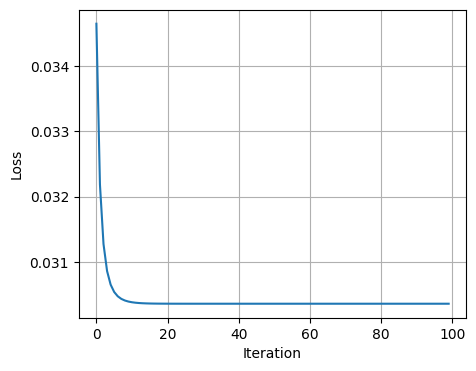

In [23]:
plt.figure(figsize = (5, 4))
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Check the estimated parameters of `SGDClassifier`.

In [24]:
weights = pipe_sgd_l2[1].coef_
bias = pipe_sgd_l2[1].intercept_
print('Weights: ', weights.shape)
print('Bias: ', bias)

Weights:  (1, 784)
Bias:  [-4.43001892]


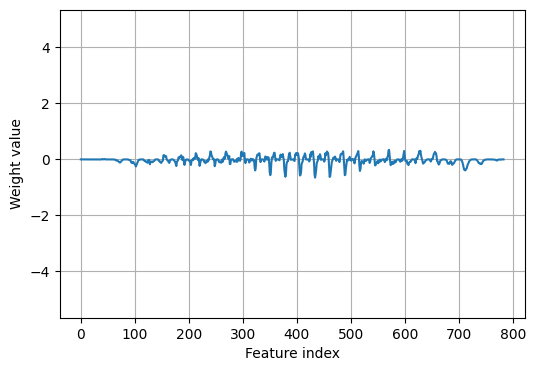

In [25]:
plt.figure(figsize = (6, 4))
plt.plot(np.arange(784), weights[0, :])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim((np.min(weights)-5, np.max(weights)+5))
plt.grid()

In [26]:
num_zero_w = weights.shape[1] - np.count_nonzero(weights)
print('Number of weights with value zero:%f'%num_zero_w)

Number of weights with value zero:67.000000


In [27]:
print('Training accuracy %.2f'%pipe_sgd_l2.score(x_train, y_train_0))
print('Testing accuracy %.2f'%pipe_sgd_l2.score(x_test, y_test_0))

Training accuracy 0.99
Testing accuracy 0.99


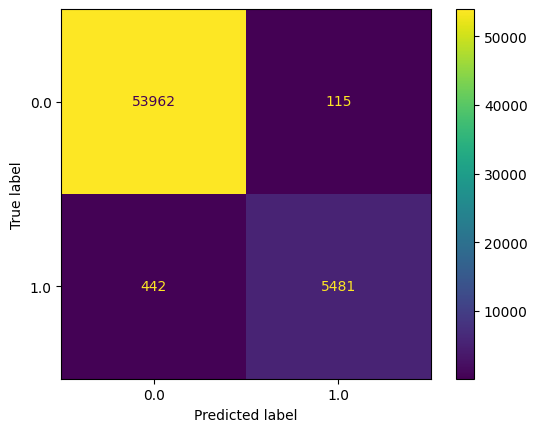

In [28]:
y_hat_train_0 = pipe_sgd_l2.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0)

In [29]:
print(classification_report(y_train_0, y_hat_train_0, digits=3))

              precision    recall  f1-score   support

         0.0      0.992     0.998     0.995     54077
         1.0      0.979     0.925     0.952      5923

    accuracy                          0.991     60000
   macro avg      0.986     0.962     0.973     60000
weighted avg      0.991     0.991     0.991     60000



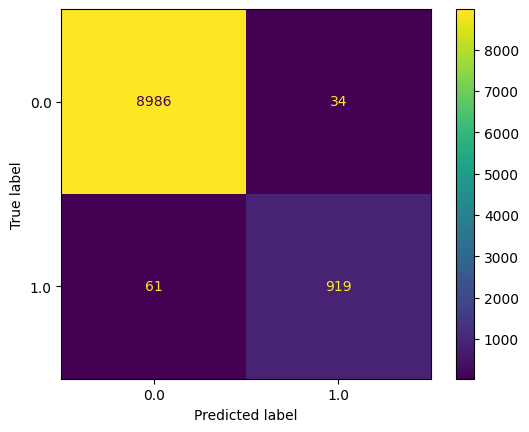

In [30]:
y_hat_test_0 = pipe_sgd_l2.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_test_0)

In [31]:
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9020
         1.0       0.96      0.94      0.95       980

    accuracy                           0.99     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.99      0.99      0.99     10000



### Displaying input image and its prediction



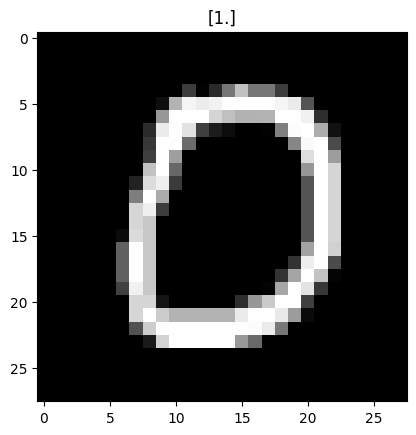

In [32]:
index = 10 # try some other index
plt.imshow(x_test[index, : ].reshape(28,28), cmap='gray')
pred = pipe_sgd.predict(x_test[index].reshape(1, -1))
plt.title(str(pred))
plt.show()

Let's plot a few images and their respective **predictions** with SGDclassifier trained without regularization.

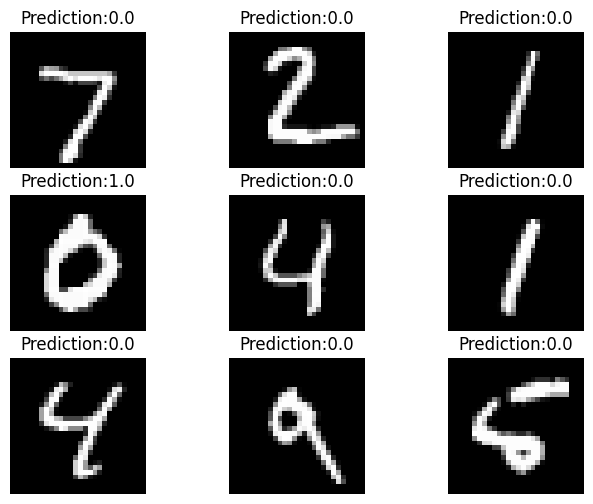

In [33]:
y_hat_test_0 = pipe_sgd.predict(x_test)
num_images = 9              # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8, 6))
idx_offset = 0              # display "num_images" starting from idx_offset

for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(x_test[index+j].reshape(28,28), cmap='gray') # we should not use x_train_with_dummy
    ax[i,j].set_title('Prediction:{0}'.format(str(y_hat_test_0[index+j])))
    ax[i,j].set_axis_off()

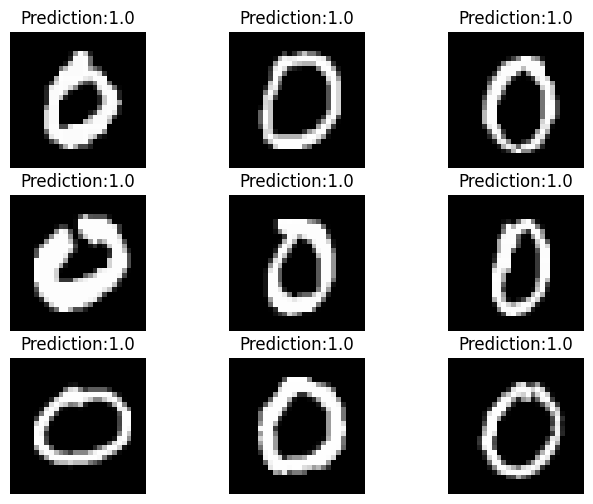

In [34]:
indx_0 = np.where(y_test_0 == 1)
zeroImgs = x_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]

num_images = 9              # Choose a square number
factor = int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8, 6))
idx_offset = 0              # Display "num_images" starting from idx_offset

for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(zeroImgs[index+j].reshape(28, 28), cmap='gray')
    ax[i,j].set_title('Prediction:{0}'.format(str(zeroLabls[index+j])))
    ax[i,j].set_axis_off()

## Hyper-parameter tuning

The learning rate and regularization rate are two important hyper-parameters of sgdclassifier.

Let's use `RandomizedSearchCV()` and draw the value from the log-uniform distribution to find a better combination of `eta and alpha`



In [35]:
eta_grid = loguniform(1e-3, 1e-1)
alpha_grid = loguniform(1e-7, 1e-1)

Note that, `eta_grid` & `alpha_grid` are objects that contain a method called `rvs()` which can be called to get random values of given size.
Therefore, we pass this `eta_grid` & `alpha_grid`  objects to `RandomizedSearchCV()`. Internally, it makes use of this `rvs()` method of these objects for sampling.

In [36]:
print(eta_grid.rvs(10, random_state=42))

[0.00561152 0.07969455 0.02910636 0.01575132 0.00205134 0.00205111
 0.00130667 0.05399484 0.01593052 0.02607025]


In [37]:
estimator= SGDClassifier(loss='log_loss',
                        penalty='l2',
                        max_iter=100,
                        warm_start=False,
                        learning_rate='constant',
                        eta0=0.01,
                        alpha=0,
                        random_state=1729)

pipe_sgd_hpt = Pipeline([
    ('scaler', MinMaxScaler()),
    ('sgdclassifier', estimator)
])

pipe_sgd_hpt

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('sgdclassifier',
                 SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant',
                               loss='log_loss', max_iter=100,
                               random_state=1729))])

In [38]:
param_distributions = {
    'sgdclassifier__eta0': eta_grid,
    'sgdclassifier__alpha': alpha_grid
}

scores = RandomizedSearchCV(pipe_sgd_hpt,
                            param_distributions,
                            cv=5,
                            scoring='precision',
                            n_iter=10,
                            refit=True,
                            random_state=1729)

In [39]:
# It take quite a long time to finish
scores.fit(x_train, y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('sgdclassifier',
                                              SGDClassifier(alpha=0, eta0=0.01,
                                                            learning_rate='constant',
                                                            loss='log_loss',
                                                            max_iter=100,
                                                            random_state=1729))]),
                   param_distributions={'sgdclassifier__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78cc6f90c9d0>,
                                        'sgdclassifier__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78cc70090390>},
                   random_state=1729, scoring='precision')

In [40]:
pprint(scores.cv_results_)

{'mean_fit_time': array([2.14594369, 2.00185843, 1.57937555, 2.15385928, 1.72474189,
       2.0708128 , 2.2107069 , 1.98307643, 1.58299284, 1.7725409 ]),
 'mean_score_time': array([0.07777772, 0.07871709, 0.07731872, 0.07368522, 0.08055234,
       0.07990041, 0.07290645, 0.07982702, 0.07523451, 0.0791914 ]),
 'mean_test_score': array([0.96460118, 0.96414504, 0.96737133, 0.96151669, 0.9884984 ,
       0.96578734, 0.96148015, 0.96354983, 0.98956494, 0.96552555]),
 'param_sgdclassifier__alpha': masked_array(data=[1.8747854362378868e-06, 3.476412314661179e-05,
                   0.0014239854561506498, 5.312503633759699e-06,
                   0.05828730756092901, 2.521634683952945e-07,
                   0.00011448262369494136, 1.1186816059037773e-05,
                   0.05812154350589123, 0.0032689146207270374],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=1e+20),
 'param_sgdclassifier__eta0': masked_array(

Let us pick the best  estimator from the results

In [41]:
print('Best combination:(alpha:{0:.8f}, eta:{1:.5f})'.format(scores.best_params_['sgdclassifier__alpha'],
                                                             scores.best_params_['sgdclassifier__eta0']))

Best combination:(alpha:0.05812154, eta:0.01691)


In [42]:
best_sgd_clf = scores.best_estimator_
y_hat_train_best_0 = best_sgd_clf.predict(x_train)

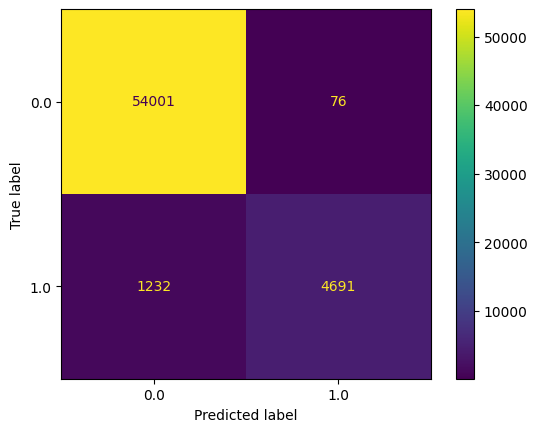

In [43]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_best_0)

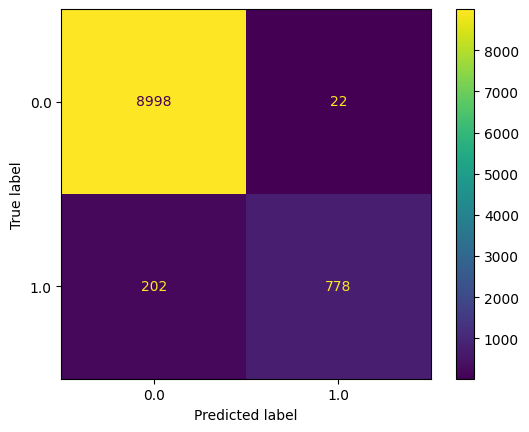

In [44]:
y_hat_test_best_0 = best_sgd_clf.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_test_best_0)

In [45]:
print(classification_report(y_train_0, y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     54077
         1.0       0.98      0.79      0.88      5923

    accuracy                           0.98     60000
   macro avg       0.98      0.90      0.93     60000
weighted avg       0.98      0.98      0.98     60000



In [46]:
print(classification_report(y_test_0, y_hat_test_best_0))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9020
         1.0       0.97      0.79      0.87       980

    accuracy                           0.98     10000
   macro avg       0.98      0.90      0.93     10000
weighted avg       0.98      0.98      0.98     10000



**Question:** Why are the evaluation metric not better than `SGDClassifier` with manual parameter setting?

**Answer**:
We need to allow the hyper-parameter tuning process to run long enough.  Try the procedure with more iterations - that will allow it to explore more in the parameter space and get us the best hyperparameters.


## Learning Curve



In [47]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2)
train_sizes, train_scores, test_scores = learning_curve(pipe_sgd,
                                                        x_train,
                                                        y_train_0,
                                                        cv=cv,
                                                        scoring='precision',
                                                        train_sizes=np.linspace(0.1, 1, 10))

The following cell computes the mean and standard deviation for each fold. This will help us visualize the variations of the score for each fold.

In [48]:
train_scores_mean = np.mean(train_scores,axis=1)
test_scores_mean = np.mean(test_scores,axis=1)
train_scores_std = np.std(train_scores,axis=1)
test_scores_std = np.std(test_scores,axis=1)

Plot the learning curve to understand the effect of number of training samples on the metrics like precision.  

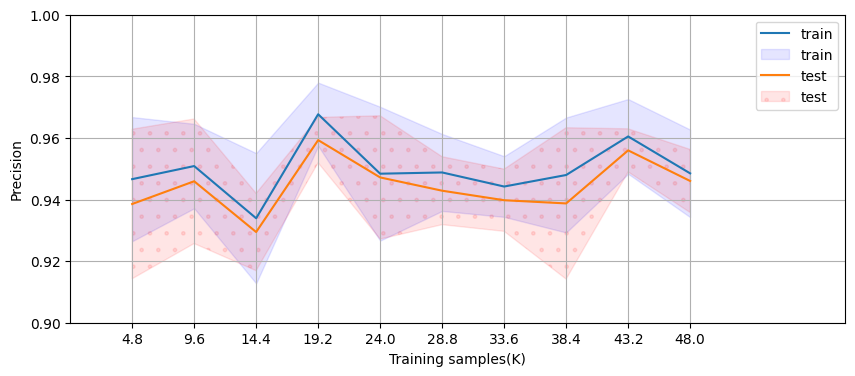

In [49]:
plt.figure(figsize=(10, 4))

# Plot training curve
plt.plot(train_sizes, train_scores_mean, label='train')
upper_bounds = train_scores_mean + train_scores_std
lower_bounds = train_scores_mean - train_scores_std
plt.fill_between(train_sizes, upper_bounds, lower_bounds,color='b', alpha=0.1, label='train')

# Plot testing curve
plt.plot(train_sizes, test_scores_mean, label='test')
upper_bounds = test_scores_mean + test_scores_std
lower_bounds = test_scores_mean - test_scores_std
plt.fill_between(train_sizes, upper_bounds, lower_bounds, color='r', alpha=0.1, hatch='.', label='test')

# Common controls
plt.xticks(ticks=train_sizes, labels=np.round(train_sizes/1000, 2))
plt.xlim((0,60000))
plt.ylim((0.9,1))
plt.grid(True)
plt.xlabel('Training samples(K)')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Classification Report
*Precision/Recall Tradeoff*


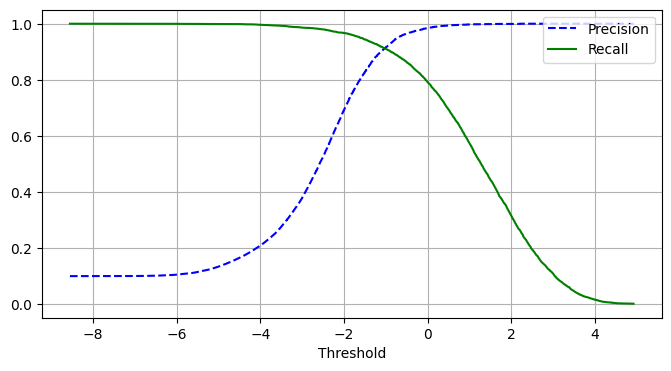

In [50]:
# Training set
y_scores = best_sgd_clf.decision_function(x_train)
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores)

plt.figure(figsize=(8, 4))

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plt.xlabel('Threshold')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

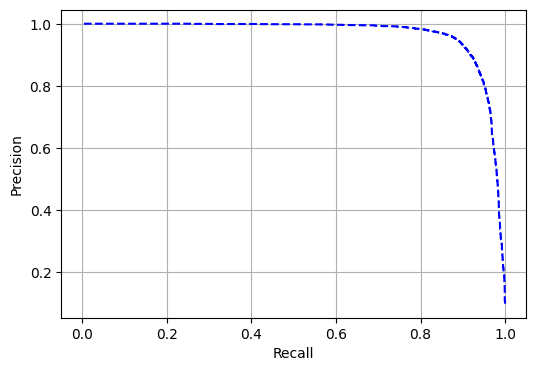

In [51]:
plt.figure(figsize=(6, 4))
plt.plot(recalls[:-1], precisions[:-1], "b--")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid()
plt.show()

In [52]:
print('AUC PR:%f'%auc(recalls[:-1],precisions[:-1]))

AUC PR:0.965547


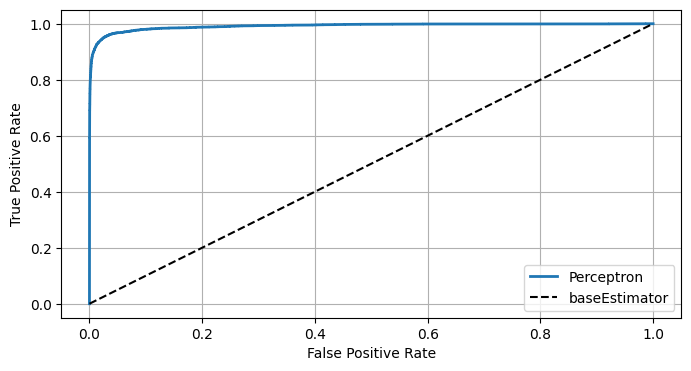

In [53]:
# Roc curve
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, linewidth=2,label='Perceptron')
plt.plot([0, 1], [0, 1], 'k--', label='baseEstimator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

In [54]:
auc = roc_auc_score(y_train_0,y_scores)
print('AUC: %.3f' % auc)

AUC: 0.992


# Part 2 - Logistic Regression

In the previous setup, we used `SGDClassifier` to train 0-detector model in an iterative manner. We can also train such a classifier by solving a set of equations obtained by setting the derivative of loss w.r.t. weights to 0. These are not linear equations and therefore we need a different set of solvers.

Sklearn uses solvers like `liblinear`, `newton-cg`, `sag`, `saga` and `lbfgs` to find the optimal weights. Regularization is applied by default.

Parameters:

```python
LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None,
                  random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False,
                  n_jobs=None, l1_ratio=None)
```

Note some of the important default parameters:
  * Regularization: `penalty='l2'``
  * Regularization rate: `C=1`
  * Solver: `solver = 'lbfgs'`

Let's implement `LogisticRegression()` **without regularization** by setting the parameter $C=\infty$. Therefore, we may expect performance close to `SGDClassifier` without regularization

## Training without regularization

**STEP 1**: Instantiate a pipeline object with two stages:
  * The first stage contains `MinMaxScaler` for scaling the input.
  * The second state contains a `LogisticRegression` classifier with the regularization rate `C=infinity`.

**STEP 2**: Train the pipeline with feature matrix `x_train` and label vector `y_train_0`.

In [55]:
pipe_logit = make_pipeline(MinMaxScaler(),
                           LogisticRegression(random_state=1729,
                                              solver='lbfgs',
                                              C=np.inf))
pipe_logit.fit(x_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

By executing this cell, we trained our `LogisticRegression` classifier, which can be used for making predictions on the new inputs.

## Hyperparameter search

In this section, we will search for the best value for parameter `C` under certain `scoring` function.

### With `GridSearchCV`

In the previous cell, we trained `LogisticRegression` classifier with `C = infinity`.  You may wonder if that's the best value for `C` and if it is not the best value, how do we search for it? Now we will demonstrate how to search for the best parameter value for regularization rate `C`, as an illustration, using `GridSearchCV`.  

**Note** that you can also use `RandomizedSearchCV` for this purpose.

---

In order to use `GridSearchCV`, we first define a set of values that we want to try out for `C`.  The best value of `C` will be found from this set.

We define the `pipleline` object exactly like before with one exception: we have set parameter value C to 1 in `LogisticRegression` estimator.  You can set it to any value as the best value would be searched with grid search.

The additional step here is to instatiate a `GridSearchCV` object with a `pipeline` estimator, parameter grid specification and `f1` as a `scoring` function.

**Note** that you can use other scoring functions like `precision`, `recall`, however the value of `C` is found such that the given scoring function is optimized.

In [56]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('logistic', LogisticRegression(C=1.0, random_state=1729))
])

param_grid = {
    'logistic__C': [0, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
}

pipe_logit_cv = GridSearchCV(pipe, param_grid, scoring='f1')
pipe_logit_cv.fit(x_train, y_train_0)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logistic__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0]},
             scoring='f1')

The `GridSearchCV` finds the best value of `C` and refits the estimator by default on the entire training set.  This gives us the logistic regression classifier with best value of `C`.

We can check the value of the best parameter by accessing the `best_params_`
member variable of the `GridSearchCV` object.

In [57]:
pipe_logit_cv.best_params_

{'logistic__C': 0.1}

and the best score can be found in `best_score_` member variable and can be obtained as follows:

In [58]:
pipe_logit_cv.best_score_

np.float64(0.9582781080330685)

The best estimator can be accessed with `best_estimator_` member variable.

In [59]:
pipe_logit_cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=0.1, random_state=1729))])

### With `LogisticRegressionCV`

Instead of using `GridSearchCV` for finding the best value for parameter `C`, we can use `LogisticRegressionCV` for performing the same job.

* **STEP 1**: Here we make use of `LogisticRegressionCV` estimator with number of cross validation folds `cv=5` and scoring scheme `scoring='f1'` in the `pipeline` object.

* **STEP 2**: In the second step, we train the pipeline object as before.

In [60]:
logit_cv = Pipeline([
              ('scaler', MinMaxScaler()),
              ('logistic', LogisticRegressionCV(cv=5, scoring='f1', random_state=1729))
])
logit_cv.fit(x_train, y_train_0)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic',
                 LogisticRegressionCV(cv=5, random_state=1729, scoring='f1'))])

By default, `LogisticRegressionCV` refits the model on the entire training set with the best parameter values obtained via cross validation.

## Performance evaluation

### Precision, recall and f1-score

Let's get predicition for test set with these three classifiers for detecting digit $0$ from the image:
* Logistic regression without regularization.
* Best logistic regression classifier found through `GridSearchCV`.
* Best classifier found through `LogisticRegressionCV`.

**Note** that `GridSearchCV` and `LogisticRegressionCV` by default refit the classifier for the best hyperparameter values.

In [61]:
pipe_logit_cv

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logistic__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0]},
             scoring='f1')

In [62]:
pipe_logit_cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=0.1, random_state=1729))])

In [63]:
lr_y_hat_0 = pipe_logit.predict(x_test)
lr_gs_y_hat_0 = pipe_logit_cv.predict(x_test)
lr_cv_y_hat_0 = logit_cv.predict(x_test)

We will compare **precision**, **recall** and **F1 score** for the three classifiers.

In [64]:
precision_lr = precision_score(y_test_0, lr_y_hat_0)
recall_lr = recall_score(y_test_0, lr_y_hat_0)

precision_lr_gs = precision_score(y_test_0, lr_gs_y_hat_0)
recall_lr_gs = recall_score(y_test_0, lr_gs_y_hat_0)

precision_lr_cv = precision_score(y_test_0, lr_cv_y_hat_0)
recall_lr_cv = recall_score(y_test_0, lr_cv_y_hat_0)

print (f"LogReg: precision={precision_lr}, recall={recall_lr}")
print (f"GridSearch: precision={precision_lr_gs}, recall={recall_lr_gs}")
print (f"LogRegCV: precision={precision_lr_cv}, recall={recall_lr_cv}")

LogReg: precision=0.9544994944388271, recall=0.963265306122449
GridSearch: precision=0.9555555555555556, recall=0.9653061224489796
LogRegCV: precision=0.9526686807653575, recall=0.9653061224489796


Note that all three classifiers have roughly the same performance as measured with precision and recall.
* The `LogisticRegression` classifier obtained through `GridSearchCV` has the highest precision - marginally higher than the other two classifiers.
* The `LogisticRegression` classifier obtained through `LogisticRegressionCV` has the highest recall - marginally higher than the other two classifiers.

### Using PR-curve



In [65]:
y_scores_lr = pipe_logit.decision_function(x_test)
precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(
    y_test_0, y_scores_lr)

y_scores_lr_gs = pipe_logit_cv.decision_function(x_test)
precisions_lr_gs, recalls_lr_gs, thresholds_lr_gs = precision_recall_curve(
    y_test_0, y_scores_lr_gs)

y_scores_lr_cv = logit_cv.decision_function(x_test)
precisions_lr_cv, recalls_lr_cv, thresholds_lr_cv = precision_recall_curve(
    y_test_0, y_scores_lr_cv)

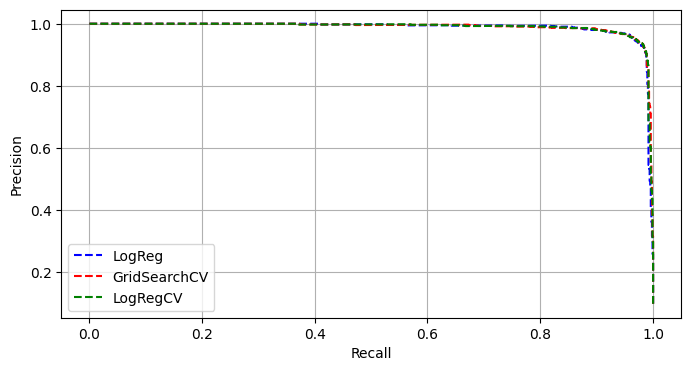

In [66]:
plt.figure(figsize=(8, 4))
plt.plot(recalls_lr[:-1], precisions_lr[:-1], 'b--', label='LogReg')
plt.plot(recalls_lr_gs[:-1], precisions_lr_gs[:-1], 'r--', label='GridSearchCV')
plt.plot(recalls_lr_cv[:-1], precisions_lr_cv[:-1], 'g--', label='LogRegCV')

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

Note that the PR curves for all three classifiers overlap significantly.

Let's calculate area under the PR curve:

In [69]:
auc_lr = auc(recalls_lr[:-1], precisions_lr[:-1])
auc_lr_gs = auc(recalls_lr_gs[:-1], precisions_lr_gs[:-1])
auc_lr_cv = auc(recalls_lr_cv[:-1], precisions_lr_cv[:-1])

print ("AUC-PR for logistic regression:", auc_lr)
print ("AUC-PR for grid search:", auc_lr_gs)
print ("AUC-PR for logistic regression CV:", auc_lr_cv)

AUC-PR for logistic regression: 0.9872513414335629
AUC-PR for grid search: 0.9884540467590757
AUC-PR for logistic regression CV: 0.9882682337599971


Observe that the AUC for all three classifier is roughly the same with `LogisticRegression` classifier obtained through cross validation and grid search have slightly higher AUC under PR curve.

### Confusion matrix

We show a confusion matrix for test set with logistic regression classifier:

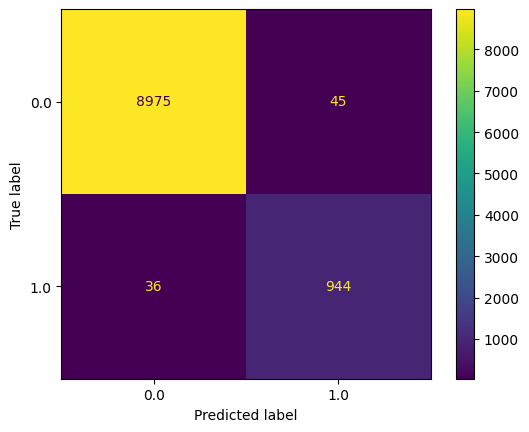

In [70]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_y_hat_0)

Confusion matrix for test set with logistic regression classifier obtained through **grid search**:

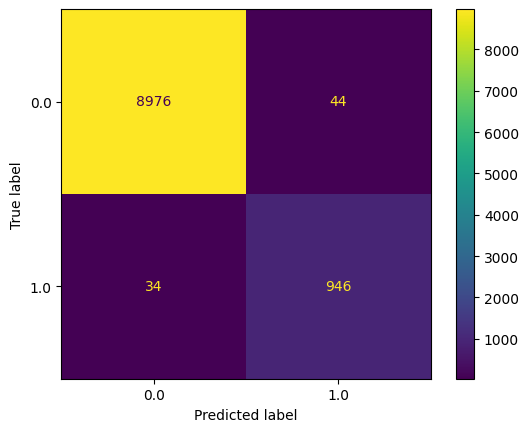

In [71]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_gs_y_hat_0)

Confusion matrix for test set with logistic regression classifier obtained through **cross validation**:

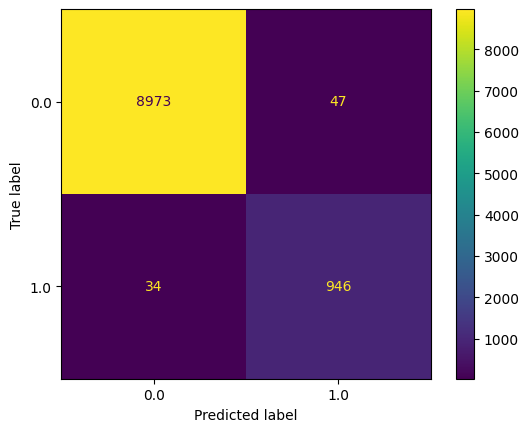

In [72]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_cv_y_hat_0)

# Part 3 - Ridge Classifier

Ridge classifier cast the problem as least-square classification and finds the optimal weight using some matrix decomposition technique such as SVD.

To train the ridge classifier, the labels should be $y \in \{+1,-1\}$.

The classifier also by default implements $L2$ regularization.  However, we first implement it without regularization by setting `alpha = 0`

In [73]:
# Intialize new variable names with all -1
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

# find indices of digit 0 image
indx_0 = np.where(y_train == '0')

# use those indices to modify y_train_0 & y_test_0
y_train_0[indx_0] = 1

indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

First take a look into the parameters of the class
``` python
RidgeClassifier(alpha=1.0, *, fit_intercept=True, copy_X=True, max_iter=None, tol=0.001,
                class_weight=None, solver='auto', positive=False, random_state=None)
```

In [74]:
estimator = RidgeClassifier(alpha=0)
pipe_ridge = make_pipeline(MinMaxScaler(), estimator)
pipe_ridge.fit(x_train,y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))])

Performance

In [75]:
y_hat_test_0 = pipe_ridge.predict(x_test)
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99      9020
         1.0       0.95      0.87      0.91       980

    accuracy                           0.98     10000
   macro avg       0.97      0.93      0.95     10000
weighted avg       0.98      0.98      0.98     10000



## Cross Validation

In [76]:
cv_bin_ridge_clf = cross_validate(
                      pipe_ridge, x_train, y_train_0, cv=5,
                      scoring=['precision', 'recall', 'f1'],
                      return_train_score=True,
                      return_estimator=True)
pprint(cv_bin_ridge_clf)

{'estimator': [Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))])],
 'fit_time': array([15.65907145, 16.3174262 , 13.99657321, 13.71745324, 13.73864913]),
 'score_time': array([0.09268117, 0.09073734, 0.09616184, 0.18006873, 0.17422557]),
 'test_f1': array([0.90740741, 0.9021691 , 0.91674048, 0.89914836, 0.91160714]),
 'test_precision': array([0.94926199, 0.94790698, 0.96458527, 0.95889101, 0.96777251]),
 'test_re

In [77]:
best_estimator_id = np.argmax(cv_bin_ridge_clf['train_f1'])
best_estimator_id

np.int64(1)

In [78]:
best_estimator = cv_bin_ridge_clf['estimator'][best_estimator_id]

Let's evaluate the performance of the best classifier on the test set:

In [79]:
y_hat_test_0 = best_estimator.predict(x_test)
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99      9020
         1.0       0.95      0.88      0.91       980

    accuracy                           0.98     10000
   macro avg       0.97      0.94      0.95     10000
weighted avg       0.98      0.98      0.98     10000



## Further exploration
Let's see what these classifiers learnt about the digit 0

<Figure size 400x400 with 0 Axes>

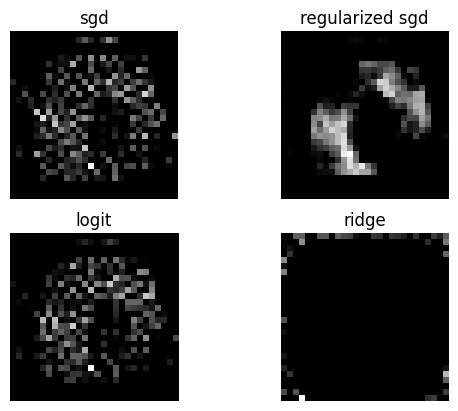

In [80]:
models = (pipe_sgd, pipe_sgd_l2, pipe_logit, pipe_ridge)
titles = ('sgd', 'regularized sgd', 'logit', 'ridge')
plt.figure(figsize=(4, 4))
plt.subplots(2, 2)
for i in range(0, 4):
  w = models[i][1].coef_
  w_matrix = w.reshape(28, 28)
  w_matrix[w_matrix < 0] = 0 # Just set the value less than zero to zero
  plt.subplot(2, 2, i+1)
  plt.imshow(w_matrix, cmap='gray')
  plt.title(titles[i])
  plt.axis('off')
  plt.grid(False)
fig.show()

# Part 4 - Multiclass Classifier (OneVsAll)


## Multiclass Logit with SGD

In [81]:
estimator = SGDClassifier(loss='log_loss',
                        penalty='l2',
                        max_iter=1,
                        warm_start=True,
                        eta0=0.01,
                        alpha=0,
                        learning_rate='constant',
                        random_state=1729)
pipe_sgd_ovr= make_pipeline(MinMaxScaler(), estimator)

It almost took 5 minutes for training.

In [82]:
Loss=[]
iterations= 100
for i in range(iterations):
  pipe_sgd_ovr.fit(x_train, y_train)
  y_pred = pipe_sgd_ovr.predict_proba(x_train)
  Loss.append(log_loss(y_train, y_pred))

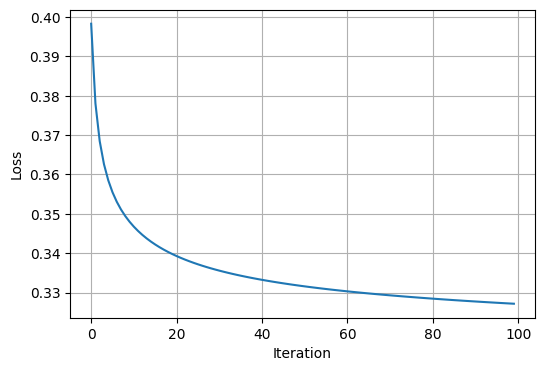

In [84]:
plt.figure(figsize = (6, 4))
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

What actually happened behind the screen is that the library automatically created 10 binary classifiers and trained them! During the inference time, the input will be passed through all the 10 classifiers and the highest score among the ouputs will be considered as the predicted class.To see it in action, let us execute the following lines of code

In [85]:
pipe_sgd_ovr[1]

SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=1, random_state=1729, warm_start=True)

In [86]:
pipe_sgd_ovr[1].coef_.shape

(10, 784)

So it is a matrix of size $10 \times 784$. A row represents the weights of a single binary classifier.

In [88]:
y_hat = pipe_sgd_ovr.predict(x_test)
y_hat[:5]

array(['7', '2', '1', '0', '4'], dtype='<U1')

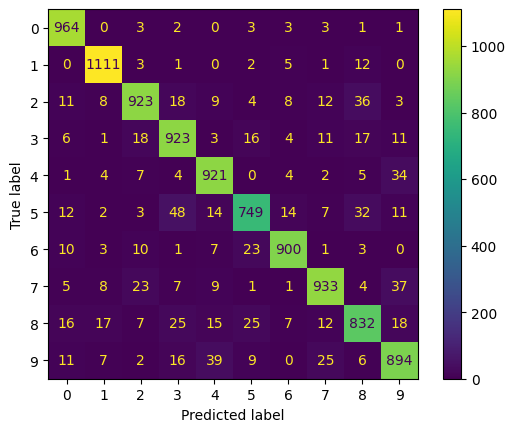

In [89]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat)

In [90]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.88      0.91      0.90      1010
           4       0.91      0.94      0.92       982
           5       0.90      0.84      0.87       892
           6       0.95      0.94      0.95       958
           7       0.93      0.91      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.92      0.91     10000



## Multi-class LogisticRegression using solvers

In [92]:
pipe_logit_ovr = make_pipeline(MinMaxScaler(),
                               LogisticRegression(random_state=1729,
                                                  solver='lbfgs',
                                                  C=np.inf))
pipe_logit_ovr.fit(x_train,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

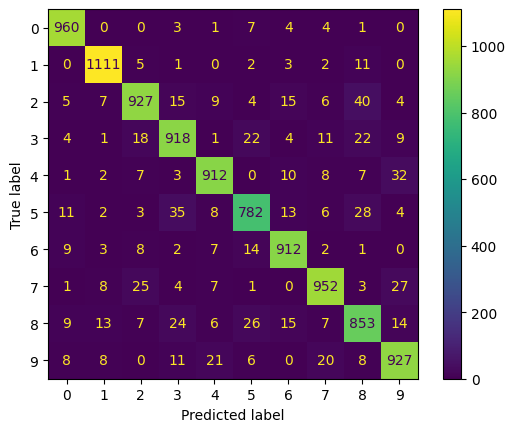

In [93]:
y_hat = pipe_logit_ovr.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat)

In [94]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



## Visualize the weight values

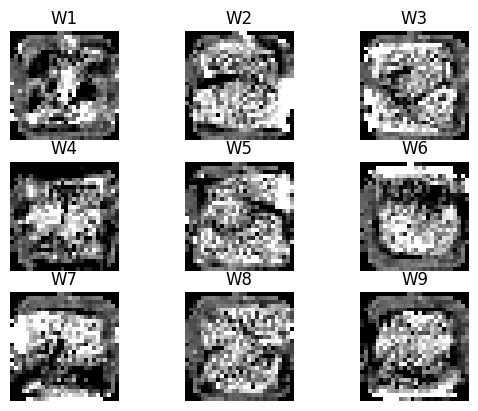

In [95]:
W = pipe_logit_ovr[1].coef_

# Normalize
W = MinMaxScaler().fit_transform(W)
fig, ax = plt.subplots(3, 3)
index = 1

for i in range(3):
  for j in range(3):
    ax[i][j].imshow(W[index,:].reshape(28,28), cmap='gray')
    ax[i][j].set_title('W{0}'.format(index))
    ax[i][j].set_axis_off()
    index += 1

**Excersise:** Multiclass classification with RidgeClassifier.